In [1]:
from pathlib import Path
import random
from pprint import pprint

subm_folder = 'segformer_b1_unet_effnet_b1_ensemble_submission_global_max_TTA'
submission_path = Path(subm_folder)
submission_path.mkdir(exist_ok=True)
submission_assets_path = submission_path / "assets"
submission_assets_path.mkdir(exist_ok=True)

submission_assets_path_effnet = submission_assets_path / "eff1_4ch"
submission_assets_path_effnet.mkdir(exist_ok=True)

submission_assets_path_segformer = submission_assets_path / "segformer-b1"
submission_assets_path_segformer.mkdir(exist_ok=True)

In [2]:
import shutil
import glob
for f in glob.glob(r'../models/timm-efficientnet-b1-*.pth'):
    print(f)
    f1 = Path(f).name
    shutil.copyfile(f,submission_assets_path_effnet/f1)
    
    
for f in glob.glob(r'../models/segformer_b1-*.pth'):
    print(f)
    f1 = Path(f).name
    shutil.copyfile(f,submission_assets_path_segformer/f1)
    

../models\timm-efficientnet-b1-fold0.pth
../models\timm-efficientnet-b1-fold1.pth
../models\timm-efficientnet-b1-fold2.pth
../models\timm-efficientnet-b1-fold3.pth
../models\timm-efficientnet-b1-fold4.pth
../models\segformer_b1-fold0.pth
../models\segformer_b1-fold2.pth
../models\segformer_b1-fold4.pth


In [3]:
%%file $subm_folder/segformer.py
import math

import torch
import torch.nn.functional as F
from packaging import version
from torch import nn
import collections
from collections import OrderedDict, UserDict
from typing import Any, BinaryIO, ContextManager, Dict, List, Optional, Tuple, Union

class ModelOutput(OrderedDict):
    """
    Base class for all model outputs as dataclass. Has a `__getitem__` that allows indexing by integer or slice (like a
    tuple) or strings (like a dictionary) that will ignore the `None` attributes. Otherwise behaves like a regular
    python dictionary.
    <Tip warning={true}>
    You can't unpack a `ModelOutput` directly. Use the [`~file_utils.ModelOutput.to_tuple`] method to convert it to a
    tuple before.
    </Tip>
    """

    def __post_init__(self):
        class_fields = fields(self)

        # Safety and consistency checks
        if not len(class_fields):
            raise ValueError(f"{self.__class__.__name__} has no fields.")
        if not all(field.default is None for field in class_fields[1:]):
            raise ValueError(f"{self.__class__.__name__} should not have more than one required field.")

        first_field = getattr(self, class_fields[0].name)
        other_fields_are_none = all(getattr(self, field.name) is None for field in class_fields[1:])

        if other_fields_are_none and not is_tensor(first_field):
            if isinstance(first_field, dict):
                iterator = first_field.items()
                first_field_iterator = True
            else:
                try:
                    iterator = iter(first_field)
                    first_field_iterator = True
                except TypeError:
                    first_field_iterator = False

            # if we provided an iterator as first field and the iterator is a (key, value) iterator
            # set the associated fields
            if first_field_iterator:
                for element in iterator:
                    if (
                        not isinstance(element, (list, tuple))
                        or not len(element) == 2
                        or not isinstance(element[0], str)
                    ):
                        break
                    setattr(self, element[0], element[1])
                    if element[1] is not None:
                        self[element[0]] = element[1]
            elif first_field is not None:
                self[class_fields[0].name] = first_field
        else:
            for field in class_fields:
                v = getattr(self, field.name)
                if v is not None:
                    self[field.name] = v

    def __delitem__(self, *args, **kwargs):
        raise Exception(f"You cannot use ``__delitem__`` on a {self.__class__.__name__} instance.")

    def setdefault(self, *args, **kwargs):
        raise Exception(f"You cannot use ``setdefault`` on a {self.__class__.__name__} instance.")

    def pop(self, *args, **kwargs):
        raise Exception(f"You cannot use ``pop`` on a {self.__class__.__name__} instance.")

    def update(self, *args, **kwargs):
        raise Exception(f"You cannot use ``update`` on a {self.__class__.__name__} instance.")

    def __getitem__(self, k):
        if isinstance(k, str):
            inner_dict = {k: v for (k, v) in self.items()}
            return inner_dict[k]
        else:
            return self.to_tuple()[k]

    def __setattr__(self, name, value):
        if name in self.keys() and value is not None:
            # Don't call self.__setitem__ to avoid recursion errors
            super().__setitem__(name, value)
        super().__setattr__(name, value)

    def __setitem__(self, key, value):
        # Will raise a KeyException if needed
        super().__setitem__(key, value)
        # Don't call self.__setattr__ to avoid recursion errors
        super().__setattr__(key, value)

    def to_tuple(self) -> Tuple[Any]:
        """
        Convert self to a tuple containing all the attributes/keys that are not `None`.
        """
        return tuple(self[k] for k in self.keys())
    
    
class BaseModelOutput(ModelOutput):


    last_hidden_state: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None
        
class SequenceClassifierOutput(ModelOutput):

    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None


def gelu_python(x):
    """
    Original Implementation of the GELU activation function in Google BERT repo when initially created. For
    information: OpenAI GPT's GELU is slightly different (and gives slightly different results): 0.5 * x * (1 +
    torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3)))) This is now written in C in nn.functional
    Also see the Gaussian Error Linear Units paper: https://arxiv.org/abs/1606.08415
    """
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))


def gelu_new(x):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT). Also see
    the Gaussian Error Linear Units paper: https://arxiv.org/abs/1606.08415
    """
    return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))


if version.parse(torch.__version__) < version.parse("1.4"):
    gelu = gelu_python
else:
    gelu = nn.functional.gelu


def gelu_fast(x):
    return 0.5 * x * (1.0 + torch.tanh(x * 0.7978845608 * (1.0 + 0.044715 * x * x)))


def quick_gelu(x):
    return x * torch.sigmoid(1.702 * x)


def _silu_python(x):
    """
    See Gaussian Error Linear Units (Hendrycks et al., https://arxiv.org/abs/1606.08415) where the SiLU (Sigmoid Linear
    Unit) was originally introduced and coined, and see Sigmoid-Weighted Linear Units for Neural Network Function
    Approximation in Reinforcement Learning (Elfwing et al., https://arxiv.org/abs/1702.03118) and Swish: a Self-Gated
    Activation Function (Ramachandran et al., https://arxiv.org/abs/1710.05941v1) where the SiLU was experimented with
    later.
    """
    return x * torch.sigmoid(x)


if version.parse(torch.__version__) < version.parse("1.7"):
    silu = _silu_python
else:
    silu = nn.functional.silu


def _mish_python(x):
    """
    See Mish: A Self-Regularized Non-Monotonic Activation Function (Misra., https://arxiv.org/abs/1908.08681). Also
    visit the official repository for the paper: https://github.com/digantamisra98/Mish
    """
    return x * torch.tanh(nn.functional.softplus(x))


if version.parse(torch.__version__) < version.parse("1.9"):
    mish = _mish_python
else:
    mish = nn.functional.mish


def linear_act(x):
    return x


ACT2FN = {
    "relu": nn.functional.relu,
    "silu": silu,
    "swish": silu,
    "gelu": gelu,
    "tanh": torch.tanh,
    "gelu_python": gelu_python,
    "gelu_new": gelu_new,
    "gelu_fast": gelu_fast,
    "quick_gelu": quick_gelu,
    "mish": mish,
    "linear": linear_act,
    "sigmoid": torch.sigmoid,
}


def get_activation(activation_string):
    if activation_string in ACT2FN:
        return ACT2FN[activation_string]
    else:
        raise KeyError(f"function {activation_string} not found in ACT2FN mapping {list(ACT2FN.keys())}")
        
class SegformerConfig():
    
    model_type = "segformer"

    def __init__(
        self,
        image_size=224,
        num_channels=3,
        num_encoder_blocks=4,
        depths=[2, 2, 2, 2],
        sr_ratios=[8, 4, 2, 1],
        hidden_sizes=[64, 128, 320, 512],
        downsampling_rates=[1, 4, 8, 16],
        patch_sizes=[7, 3, 3, 3],
        strides=[4, 2, 2, 2],
        num_attention_heads=[1, 2, 5, 8],
        mlp_ratios=[4, 4, 4, 4],
        hidden_act="gelu",
        hidden_dropout_prob=0.0,
        attention_probs_dropout_prob=0.0,
        classifier_dropout_prob=0.1,
        initializer_range=0.02,
        drop_path_rate=0.1,
        layer_norm_eps=1e-6,
        decoder_hidden_size=256,
        is_encoder_decoder=False,
        reshape_last_stage=True,
        semantic_loss_ignore_index=255,
        num_labels=1,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.image_size = image_size
        self.num_channels = num_channels
        self.num_encoder_blocks = num_encoder_blocks
        self.depths = depths
        self.sr_ratios = sr_ratios
        self.hidden_sizes = hidden_sizes
        self.downsampling_rates = downsampling_rates
        self.patch_sizes = patch_sizes
        self.strides = strides
        self.mlp_ratios = mlp_ratios
        self.num_attention_heads = num_attention_heads
        self.hidden_act = hidden_act
        self.hidden_dropout_prob = hidden_dropout_prob
        self.attention_probs_dropout_prob = attention_probs_dropout_prob
        self.classifier_dropout_prob = classifier_dropout_prob
        self.initializer_range = initializer_range
        self.drop_path_rate = drop_path_rate
        self.layer_norm_eps = layer_norm_eps
        self.decoder_hidden_size = decoder_hidden_size
        self.reshape_last_stage = reshape_last_stage
        self.semantic_loss_ignore_index = semantic_loss_ignore_index
        self.num_labels = num_labels
        
def to_2tuple(x):
    if isinstance(x, collections.abc.Iterable):
        return x
    return (x, x)


# Stochastic depth implementation
# Taken from https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/layers/drop.py
def drop_path(x, drop_prob: float = 0.0, training: bool = False):
    """
    Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks). This is the same as the
    DropConnect impl I created for EfficientNet, etc networks, however, the original name is misleading as 'Drop
    Connect' is a different form of dropout in a separate paper... See discussion:
    https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for changing the layer and
    argument names to 'drop path' rather than mix DropConnect as a layer name and use 'survival rate' as the argument.
    """
    if drop_prob == 0.0 or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks)."""

    def __init__(self, drop_prob=None):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


class SegformerOverlapPatchEmbeddings(nn.Module):
    """Construct the patch embeddings from an image."""

    def __init__(self, image_size, patch_size, stride, num_channels, hidden_size):
        super().__init__()
        image_size = to_2tuple(image_size)
        patch_size = to_2tuple(patch_size)
        self.height, self.width = image_size[0] // patch_size[0], image_size[1] // patch_size[1]
        self.num_patches = self.height * self.width
        self.proj = nn.Conv2d(
            num_channels,
            hidden_size,
            kernel_size=patch_size,
            stride=stride,
            padding=(patch_size[0] // 2, patch_size[1] // 2),
        )

        self.layer_norm = nn.LayerNorm(hidden_size)

    def forward(self, pixel_values):
        x = self.proj(pixel_values)
        _, _, height, width = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.layer_norm(x)
        return x, height, width


class SegformerEfficientSelfAttention(nn.Module):
    def __init__(self, config, hidden_size, num_attention_heads, sr_ratio):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_attention_heads = num_attention_heads

        if self.hidden_size % self.num_attention_heads != 0:
            raise ValueError(
                f"The hidden size ({self.hidden_size}) is not a multiple of the number of attention "
                f"heads ({self.num_attention_heads})"
            )

        self.attention_head_size = int(self.hidden_size / self.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(self.hidden_size, self.all_head_size)
        self.key = nn.Linear(self.hidden_size, self.all_head_size)
        self.value = nn.Linear(self.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

        self.sr_ratio = sr_ratio
        if sr_ratio > 1:
            self.sr = nn.Conv2d(hidden_size, hidden_size, kernel_size=sr_ratio, stride=sr_ratio)
            self.layer_norm = nn.LayerNorm(hidden_size)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states,
        height,
        width,
        output_attentions=False,
    ):
        query_layer = self.transpose_for_scores(self.query(hidden_states))

        if self.sr_ratio > 1:
            batch_size, seq_len, num_channels = hidden_states.shape
            hidden_states = hidden_states.permute(0, 2, 1).reshape(batch_size, num_channels, height, width)
            hidden_states = self.sr(hidden_states)
            hidden_states = hidden_states.reshape(batch_size, num_channels, -1).permute(0, 2, 1)
            hidden_states = self.layer_norm(hidden_states)

        key_layer = self.transpose_for_scores(self.key(hidden_states))
        value_layer = self.transpose_for_scores(self.value(hidden_states))

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

        attention_scores = attention_scores / math.sqrt(self.attention_head_size)

        # Normalize the attention scores to probabilities.
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

        return outputs


class SegformerSelfOutput(nn.Module):
    def __init__(self, config, hidden_size):
        super().__init__()
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        return hidden_states


class SegformerAttention(nn.Module):
    def __init__(self, config, hidden_size, num_attention_heads, sr_ratio):
        super().__init__()
        self.self = SegformerEfficientSelfAttention(
            config=config, hidden_size=hidden_size, num_attention_heads=num_attention_heads, sr_ratio=sr_ratio
        )
        self.output = SegformerSelfOutput(config, hidden_size=hidden_size)
        self.pruned_heads = set()

    def prune_heads(self, heads):
        if len(heads) == 0:
            return
        heads, index = find_pruneable_heads_and_indices(
            heads, self.self.num_attention_heads, self.self.attention_head_size, self.pruned_heads
        )

        # Prune linear layers
        self.self.query = prune_linear_layer(self.self.query, index)
        self.self.key = prune_linear_layer(self.self.key, index)
        self.self.value = prune_linear_layer(self.self.value, index)
        self.output.dense = prune_linear_layer(self.output.dense, index, dim=1)

        # Update hyper params and store pruned heads
        self.self.num_attention_heads = self.self.num_attention_heads - len(heads)
        self.self.all_head_size = self.self.attention_head_size * self.self.num_attention_heads
        self.pruned_heads = self.pruned_heads.union(heads)

    def forward(self, hidden_states, height, width, output_attentions=False):
        self_outputs = self.self(hidden_states, height, width, output_attentions)

        attention_output = self.output(self_outputs[0], hidden_states)
        outputs = (attention_output,) + self_outputs[1:]  # add attentions if we output them
        return outputs


class SegformerDWConv(nn.Module):
    def __init__(self, dim=768):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, hidden_states, height, width):
        batch_size, seq_len, num_channels = hidden_states.shape
        hidden_states = hidden_states.transpose(1, 2).view(batch_size, num_channels, height, width)
        hidden_states = self.dwconv(hidden_states)
        hidden_states = hidden_states.flatten(2).transpose(1, 2)

        return hidden_states


class SegformerMixFFN(nn.Module):
    def __init__(self, config, in_features, hidden_features=None, out_features=None):
        super().__init__()
        out_features = out_features or in_features
        self.dense1 = nn.Linear(in_features, hidden_features)
        self.dwconv = SegformerDWConv(hidden_features)
        if isinstance(config.hidden_act, str):
            self.intermediate_act_fn = ACT2FN[config.hidden_act]
        else:
            self.intermediate_act_fn = config.hidden_act
        self.dense2 = nn.Linear(hidden_features, out_features)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, height, width):
        hidden_states = self.dense1(hidden_states)
        hidden_states = self.dwconv(hidden_states, height, width)
        hidden_states = self.intermediate_act_fn(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.dense2(hidden_states)
        hidden_states = self.dropout(hidden_states)
        return hidden_states


class SegformerLayer(nn.Module):
    """This corresponds to the Block class in the original implementation."""

    def __init__(self, config, hidden_size, num_attention_heads, drop_path, sr_ratio, mlp_ratio):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(hidden_size)
        self.attention = SegformerAttention(
            config, hidden_size=hidden_size, num_attention_heads=num_attention_heads, sr_ratio=sr_ratio
        )
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.layer_norm_2 = nn.LayerNorm(hidden_size)
        mlp_hidden_size = int(hidden_size * mlp_ratio)
        self.mlp = SegformerMixFFN(config, in_features=hidden_size, hidden_features=mlp_hidden_size)

    def forward(self, hidden_states, height, width, output_attentions=False):
        self_attention_outputs = self.attention(
            self.layer_norm_1(hidden_states),  # in Segformer, layernorm is applied before self-attention
            height,
            width,
            output_attentions=output_attentions,
        )

        attention_output = self_attention_outputs[0]
        outputs = self_attention_outputs[1:]  # add self attentions if we output attention weights

        # first residual connection (with stochastic depth)
        attention_output = self.drop_path(attention_output)
        hidden_states = attention_output + hidden_states

        mlp_output = self.mlp(self.layer_norm_2(hidden_states), height, width)

        # second residual connection (with stochastic depth)
        mlp_output = self.drop_path(mlp_output)
        layer_output = mlp_output + hidden_states

        outputs = (layer_output,) + outputs

        return outputs
class SegformerEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # stochastic depth decay rule
        dpr = [x.item() for x in torch.linspace(0, config.drop_path_rate, sum(config.depths))]

        # patch embeddings
        embeddings = []
        for i in range(config.num_encoder_blocks):
            embeddings.append(
                SegformerOverlapPatchEmbeddings(
                    image_size=config.image_size // config.downsampling_rates[i],
                    patch_size=config.patch_sizes[i],
                    stride=config.strides[i],
                    num_channels=config.num_channels if i == 0 else config.hidden_sizes[i - 1],
                    hidden_size=config.hidden_sizes[i],
                )
            )
        self.patch_embeddings = nn.ModuleList(embeddings)

        # Transformer blocks
        blocks = []
        cur = 0
        for i in range(config.num_encoder_blocks):
            # each block consists of layers
            layers = []
            if i != 0:
                cur += config.depths[i - 1]
            for j in range(config.depths[i]):
                layers.append(
                    SegformerLayer(
                        config,
                        hidden_size=config.hidden_sizes[i],
                        num_attention_heads=config.num_attention_heads[i],
                        drop_path=dpr[cur + j],
                        sr_ratio=config.sr_ratios[i],
                        mlp_ratio=config.mlp_ratios[i],
                    )
                )
            blocks.append(nn.ModuleList(layers))

        self.block = nn.ModuleList(blocks)

        # Layer norms
        self.layer_norm = nn.ModuleList(
            [nn.LayerNorm(config.hidden_sizes[i]) for i in range(config.num_encoder_blocks)]
        )

    def forward(
        self,
        pixel_values,
        output_attentions=False,
        output_hidden_states=False,
        return_dict=True,
    ):
        all_hidden_states = () if output_hidden_states else None
        all_self_attentions = () if output_attentions else None

        batch_size = pixel_values.shape[0]

        hidden_states = pixel_values
        for idx, x in enumerate(zip(self.patch_embeddings, self.block, self.layer_norm)):
            embedding_layer, block_layer, norm_layer = x
            # first, obtain patch embeddings
            hidden_states, height, width = embedding_layer(hidden_states)
            # second, send embeddings through blocks
            for i, blk in enumerate(block_layer):
                layer_outputs = blk(hidden_states, height, width, output_attentions)
                hidden_states = layer_outputs[0]
                if output_attentions:
                    all_self_attentions = all_self_attentions + (layer_outputs[1],)
            # third, apply layer norm
            hidden_states = norm_layer(hidden_states)
            # fourth, optionally reshape back to (batch_size, num_channels, height, width)
            if idx != len(self.patch_embeddings) - 1 or (
                idx == len(self.patch_embeddings) - 1 and self.config.reshape_last_stage
            ):
                hidden_states = hidden_states.reshape(batch_size, height, width, -1).permute(0, 3, 1, 2).contiguous()
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(v for v in [hidden_states, all_hidden_states, all_self_attentions] if v is not None)
        return BaseModelOutput(
            last_hidden_state=hidden_states,
            hidden_states=all_hidden_states,
            attentions=all_self_attentions,
        )


class SegformerPreTrainedModel():
    """
    An abstract class to handle weights initialization and a simple interface for downloading and loading pretrained
    models.
    """

    config_class = SegformerConfig
    base_model_prefix = "segformer"
    main_input_name = "pixel_values"

    def _init_weights(self, module):
        """Initialize the weights"""
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
class SegformerModel(nn.Module):
    def __init__(self, config):
        #super().__init__(config)
        super().__init__()
        self.config = config

        # hierarchical Transformer encoder
        self.encoder = SegformerEncoder(config)

        # Initialize weights and apply final processing
        #self.post_init()

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(self, pixel_values, output_attentions=None, output_hidden_states=None, return_dict=None):
        r"""
        Returns:
        Examples:
        ```python
        >>> from transformers import SegformerFeatureExtractor, SegformerModel
        >>> from PIL import Image
        >>> import requests
        >>> feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
        >>> model = SegformerModel("nvidia/segformer-b0-finetuned-ade-512-512")
        >>> url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
        >>> image = Image.open(requests.get(url, stream=True).raw)
        >>> inputs = feature_extractor(images=image, return_tensors="pt")
        >>> outputs = model(**inputs)
        >>> sequence_output = outputs.last_hidden_state
        ```"""

        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        encoder_outputs = self.encoder(
            pixel_values,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = encoder_outputs[0]

        if not return_dict:
            return (sequence_output,) + encoder_outputs[1:]

        return BaseModelOutput(
            last_hidden_state=sequence_output,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
        )


class SegformerMLP(nn.Module):
    """
    Linear Embedding.
    """

    def __init__(self, config: SegformerConfig, input_dim):
        super().__init__()
        self.proj = nn.Linear(input_dim, config.decoder_hidden_size)

    def forward(self, hidden_states: torch.Tensor):
        hidden_states = hidden_states.flatten(2).transpose(1, 2)
        hidden_states = self.proj(hidden_states)
        return hidden_states
    
class SegformerDecodeHead(nn.Module):
    def __init__(self, config):
        #super().__init__(config)
        super().__init__()
        # linear layers which will unify the channel dimension of each of the encoder blocks to the same config.decoder_hidden_size
        mlps = []
        for i in range(config.num_encoder_blocks):
            mlp = SegformerMLP(config, input_dim=config.hidden_sizes[i])
            mlps.append(mlp)
        self.linear_c = nn.ModuleList(mlps)

        # the following 3 layers implement the ConvModule of the original implementation
        self.linear_fuse = nn.Conv2d(
            in_channels=config.decoder_hidden_size * config.num_encoder_blocks,
            out_channels=config.decoder_hidden_size,
            kernel_size=1,
            bias=False,
        )
        self.batch_norm = nn.BatchNorm2d(config.decoder_hidden_size)
        self.activation = nn.ReLU()

        self.dropout = nn.Dropout(config.classifier_dropout_prob)
        self.classifier = nn.Conv2d(config.decoder_hidden_size, config.num_labels, kernel_size=1)

    def forward(self, encoder_hidden_states):
        batch_size, _, _, _ = encoder_hidden_states[-1].shape
        all_hidden_states = ()
        for encoder_hidden_state, mlp in zip(encoder_hidden_states, self.linear_c):
            # unify channel dimension
            height, width = encoder_hidden_state.shape[2], encoder_hidden_state.shape[3]
            encoder_hidden_state = mlp(encoder_hidden_state)
            encoder_hidden_state = encoder_hidden_state.permute(0, 2, 1)
            encoder_hidden_state = encoder_hidden_state.reshape(batch_size, -1, height, width)
            # upsample
            encoder_hidden_state = nn.functional.interpolate(
                encoder_hidden_state, size=encoder_hidden_states[0].size()[2:], mode="bilinear", align_corners=False
            )
            all_hidden_states += (encoder_hidden_state,)

        hidden_states = self.linear_fuse(torch.cat(all_hidden_states[::-1], dim=1))
        hidden_states = self.batch_norm(hidden_states)
        hidden_states = self.activation(hidden_states)
        hidden_states = self.dropout(hidden_states)

        # logits are of shape (batch_size, num_labels, height/4, width/4)
        logits = self.classifier(hidden_states)

        return logits


class SegformerForSemanticSegmentation(nn.Module):
    def __init__(self, config):
        #super().__init__(config)
        super().__init__()
        self.config= config
        self.segformer = SegformerModel(config)
        self.decode_head = SegformerDecodeHead(config)
        

        # Initialize weights and apply final processing
        #self.post_init()

    def forward(
        self,
        pixel_values,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (`torch.LongTensor` of shape `(batch_size, height, width)`, *optional*):
            Ground truth semantic segmentation maps for computing the loss. Indices should be in `[0, ..., config.num_labels - 1]`. If `config.num_labels > 1`, a classification loss is computed
            (Cross-Entropy).
        Returns:
        Examples:
        ```python
        >>> from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
        >>> from PIL import Image
        >>> import requests
        >>> feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
        >>> model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
        >>> url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
        >>> image = Image.open(requests.get(url, stream=True).raw)
        >>> inputs = feature_extractor(images=image, return_tensors="pt")
        >>> outputs = model(**inputs)
        >>> logits = outputs.logits # shape (batch_size, num_labels, height/4, width/4)
        ```"""
        return_dict = True #return_dict if return_dict is not None else self.config.use_return_dict
        '''output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )'''
        output_hidden_states = False
        output_attentions= False

        outputs = self.segformer(
            pixel_values,
            output_attentions=output_attentions,
            output_hidden_states=True,  # we need the intermediate hidden states
            return_dict=return_dict,
        )

        encoder_hidden_states = outputs.hidden_states if return_dict else outputs[1]

        logits = self.decode_head(encoder_hidden_states)

        loss = None
        if labels is not None:
            if self.config.num_labels == 1:
                raise ValueError("The number of labels should be greater than one")
            else:
                # upsample logits to the images' original size
                upsampled_logits = nn.functional.interpolate(
                    logits, size=labels.shape[-2:], mode="bilinear", align_corners=False
                )
                loss_fct = CrossEntropyLoss(ignore_index=self.config.semantic_loss_ignore_index)
                loss = loss_fct(upsampled_logits, labels)

        if not return_dict:
            if output_hidden_states:
                output = (logits,) + outputs[1:]
            else:
                output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states if output_hidden_states else None,
            attentions=outputs.attentions,
        )

import torch.cuda.amp as amp

class SegFormer_b1(nn.Module):
    def __init__(self):
        super(SegFormer_b1, self).__init__()
        config = SegformerConfig()
        self.segformer = SegformerForSemanticSegmentation(config)
        self.segformer.decode_head.classifier = nn.Conv2d(256,1,kernel_size=1)
    # @torch.cuda.amp.autocast()
    def forward(self, image):
        image = image[:,0:3]
        
        batch_size = len(image)
        with amp.autocast():
            mask = self.segformer(image).logits
            mask = F.interpolate(mask, image.shape[-2:], mode="bilinear", align_corners=True)
            
        return mask
    

class AmpNet(SegFormer_b1):
    
    def __init__(self):
        super(AmpNet, self).__init__()
    @torch.cuda.amp.autocast()
    def forward(self,*args):
        return super(AmpNet, self).forward(*args)

  #True #False

Overwriting segformer_b1_unet_effnet_b1_ensemble_submission_global_max_TTA/segformer.py


In [4]:
%%file $subm_folder/cloud_model.py

from pathlib import Path
import random
from pprint import pprint

import torch
import torch.nn as nn
from timm.models.efficientnet import *
import segmentation_models_pytorch as smp
import rasterio
import segmentation_models_pytorch as smp
import numpy as np
import pandas as pd
import time
import os
import torchvision

# These transformations will be passed to our model class
class CloudDataset(torch.utils.data.Dataset):

    def __init__(self, chip_ids_df, 
                 x_path = '../data/train_features/', 
                 y_path= '../data/train_labels/', 
                 bands=[4,3,2],transforms=None):
        self.data = chip_ids_df
        self.data_path = x_path
        self.label_path = y_path
        self.bands = bands
        self.transforms = transforms

    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, idx):
        img = self.data.iloc[idx]
        chip_id = img.chip_id
        imgs = []
        for b in self.bands:
            pth = f'{self.data_path}/{chip_id}/B0{b}.tif'
            with rasterio.open(pth) as img_file:
                img = img_file.read(1).astype(float)
                img = (img/2**16).astype(np.float32)
                imgs.append(img)
        x_arr= np.stack(imgs,axis=-1)
        
        x_arr = np.transpose(x_arr, [2, 0, 1])
        sample = {"chip_id": chip_id, "chip": x_arr}

        return sample
    
class Net4CH(nn.Module):
    def __init__(self,params):
        super(Net4CH, self).__init__()

        aux_params=dict(
                        pooling='avg',             # one of 'avg', 'max'
                        dropout=0.3,               # dropout ratio, default is None
                        activation=None,      # activation function, default is None
                        classes=1,
                    ) 
        self.unet = smp.Unet(
                    encoder_name=params['backbone'],        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                    encoder_weights=params['weights'],     # use `imagenet` pre-trained weights for encoder initialization
                    in_channels=4,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                    decoder_attention_type= None,                      # model output channels (number of classes in your dataset)
                    classes=1,aux_params=aux_params
                    )



    # @torch.cuda.amp.autocast()
    def forward(self, image):
        batch_size = len(image)
        mask,logit = self.unet(image)
        return mask

Overwriting segformer_b1_unet_effnet_b1_ensemble_submission_global_max_TTA/cloud_model.py


In [5]:
%%file $subm_folder/main.py
import os
from pathlib import Path
from typing import List
from loguru import logger
import numpy as np
import pandas as pd
from tifffile import imwrite
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F
import torch.cuda.amp as amp
import typer


from segformer import SegFormer_b1,AmpNet
from cloud_model import CloudDataset,Net4CH
import torchvision

ROOT_DIRECTORY = Path("/codeexecution")
PREDICTIONS_DIRECTORY = ROOT_DIRECTORY / "predictions"
ASSETS_DIRECTORY = ROOT_DIRECTORY / "assets"
DATA_DIRECTORY = ROOT_DIRECTORY / "data"
INPUT_IMAGES_DIRECTORY = DATA_DIRECTORY / "test_features"


# Make sure the smp loader can find our torch assets because we don't have internet!
os.environ["TORCH_HOME"] = str(ASSETS_DIRECTORY / "torch")
GPU=torch.cuda.is_available()
print("GPU Available",GPU)


def get_metadata(features_dir: os.PathLike, bands: List[str]):
    """
    Given a folder of feature data, return a dataframe where the index is the chip id
    and there is a column for the path to each band's TIF image.

    Args:
        features_dir (os.PathLike): path to the directory of feature data, which should have
            a folder for each chip
        bands (list[str]): list of bands provided for each chip
    """
    chip_metadata = pd.DataFrame(index=[f"{band}_path" for band in bands])
    chip_ids = (
        pth.name for pth in features_dir.iterdir() if not pth.name.startswith(".")
    )

    for chip_id in chip_ids:
        chip_bands = [features_dir / chip_id / f"{band}.tif" for band in bands]
        chip_metadata[chip_id] = chip_bands

    return chip_metadata.transpose().reset_index().rename(columns={"index": "chip_id"})

def getModel():
    model = AmpNet()
    model.cuda()
    return model

def getModel4ch(hparams):
    unet_model = Net4CH(hparams)
    unet_model.cuda()
    return unet_model


def prediction_step(data, models,th=0.5,predictions_dir='./'):
    is_mixed_precision = True
   
    chip_ids = data['chip_id']
    images = data['chip'].float()
    images = images.cuda()

    preds = np.zeros((images.shape[0],images.shape[2],images.shape[3]))
    
    images = torch.stack([images, torchvision.transforms.functional.hflip(images),
                            torchvision.transforms.functional.vflip(images)], 0)
    n, bs, c, h, w = images.size()
    images = images.view(-1, c, h, w)
    
    #print('prediction_step',preds.shape,images.shape)
    for model in models:
        model.eval()
        with torch.no_grad():
            mask = model(images)
            
            probs1, probs2, probs3 = torch.split(mask, bs)
            probs2 = torchvision.transforms.functional.hflip(probs2)
            probs3 = torchvision.transforms.functional.vflip(probs3)
            
            mask =  (1/3)*probs1 + (1/3)*probs2 + (1/3)*probs3
            mask = mask.sigmoid()
            preds += mask[:,0].cpu().numpy()
    preds /= len(models)
    preds = ((preds>0.5)*1).astype(np.uint8)
    
    for ix in range(len(chip_ids)):
        chip_id = chip_ids[ix]
        output_path = predictions_dir / f"{chip_id}.tif"
        #if ix == 0:
        #    print('prediction_step',chip_id,preds[ix].shape,(preds[ix]==1).sum())
        imwrite(output_path, preds[ix], dtype=np.uint8)
        


hparams = {
    "backbone": 'timm-efficientnet-b1',
    "weights": "noisy-student",
}

is_mixed_precision = True
import gc
def main(
    assets_dir_path: Path = ASSETS_DIRECTORY,
    test_features_dir: Path = DATA_DIRECTORY / "test_features",
    predictions_dir: Path = PREDICTIONS_DIRECTORY,
    bands: List[str] = ["B02", "B03", "B04"],):

    if not test_features_dir.exists():
        raise ValueError(
            f"The directory for test feature images must exist and {test_features_dir} does not exist"
        )
    predictions_dir.mkdir(exist_ok=True, parents=True)
    
    logger.info("Loading model")
    # Explicitly set where we expect smp to load the saved resnet from just to be sure
    torch.hub.set_dir(assets_dir_path / "torch/hub")
    
    
    models = []
    
    assets_dir_path1 = assets_dir_path/'segformer-b1'
    model_paths = assets_dir_path1.glob('*.pth')
    
    for mp in model_paths:
        print('Loading Model from Path',mp)
        f = torch.load(mp, map_location=torch.device('cpu'))
        model = getModel()
        model.load_state_dict(f)
        model.cuda()
        models.append(model)
        del f
        gc.collect()
        
    assets_dir_path2 = assets_dir_path/'eff1_4ch'
    model_paths = assets_dir_path2.glob('*.pth')
    
    for mp in model_paths:
        print('Loading Model from Path',mp)
        f = torch.load(mp, map_location=torch.device('cpu'))
        model = getModel4ch(hparams)
        model.load_state_dict(f)
        model.cuda()
        models.append(model)
        del f
        gc.collect()
        
    torch.cuda.empty_cache()
    
    logger.info("Finding chip IDs")
    chip_id_metadata = get_metadata(test_features_dir, bands)
    
    logger.info(f"Found {len(chip_id_metadata)} test chip_ids. Generating predictions.")
    
    #create dataset and data loader
    testDataSet = val_dataset = CloudDataset(chip_id_metadata, 
                                             x_path= test_features_dir, 
                                             bands = [4,3,2,8])
    testDataLoader = torch.utils.data.DataLoader(
                        testDataSet,
                        batch_size=16,num_workers=4,shuffle=False,pin_memory=False
                        )
    
    for i,data in tqdm(enumerate(testDataLoader),total=len(testDataLoader)):
        prediction_step(data,models,predictions_dir=predictions_dir)

    logger.success(f"Inference complete.")


if __name__ == "__main__":
    typer.run(main)


Overwriting segformer_b1_unet_effnet_b1_ensemble_submission_global_max_TTA/main.py


In [6]:
import sys
sys.path.append(subm_folder)

In [7]:
from segformer_b1_unet_effnet_b1_ensemble_submission_global_max_TTA.main import main

GPU Available True


In [9]:
main( assets_dir_path=Path(f'./{subm_folder}/assets/'),
    test_features_dir=Path('../../data/train_features_sample/'),
    predictions_dir=Path('./tmp/')
    )

2022-02-15 21:22:19.477 | INFO     | segformer_b1_unet_effnet_b1_ensemble_submission_global_max_TTA.main:main:122 - Loading model


Loading Model from Path segformer_b1_unet_effnet_b1_ensemble_submission_global_max_TTA\assets\segformer-b1\segformer_b1-fold0.pth
Loading Model from Path segformer_b1_unet_effnet_b1_ensemble_submission_global_max_TTA\assets\segformer-b1\segformer_b1-fold2.pth
Loading Model from Path segformer_b1_unet_effnet_b1_ensemble_submission_global_max_TTA\assets\segformer-b1\segformer_b1-fold4.pth
Loading Model from Path segformer_b1_unet_effnet_b1_ensemble_submission_global_max_TTA\assets\eff1_4ch\timm-efficientnet-b1-fold0.pth
Loading Model from Path segformer_b1_unet_effnet_b1_ensemble_submission_global_max_TTA\assets\eff1_4ch\timm-efficientnet-b1-fold1.pth
Loading Model from Path segformer_b1_unet_effnet_b1_ensemble_submission_global_max_TTA\assets\eff1_4ch\timm-efficientnet-b1-fold2.pth
Loading Model from Path segformer_b1_unet_effnet_b1_ensemble_submission_global_max_TTA\assets\eff1_4ch\timm-efficientnet-b1-fold3.pth
Loading Model from Path segformer_b1_unet_effnet_b1_ensemble_submission_gl

2022-02-15 21:22:23.065 | INFO     | segformer_b1_unet_effnet_b1_ensemble_submission_global_max_TTA.main:main:157 - Finding chip IDs
2022-02-15 21:22:23.080 | INFO     | segformer_b1_unet_effnet_b1_ensemble_submission_global_max_TTA.main:main:160 - Found 39 test chip_ids. Generating predictions.


  0%|          | 0/3 [00:00<?, ?it/s]

2022-02-15 21:22:43.720 | SUCCESS  | segformer_b1_unet_effnet_b1_ensemble_submission_global_max_TTA.main:main:174 - Inference complete.


In [10]:
import rasterio
import matplotlib.pyplot as plt

In [11]:
chip_ids = [pth.name for pth in Path('./tmp').iterdir() if not pth.name.startswith(".")]

d:\Anaconda3\lib\site-packages\rasterio\__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)


adwp 116766 125644


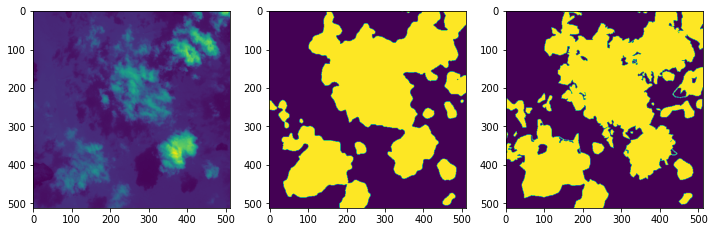

adwu 226081 166896


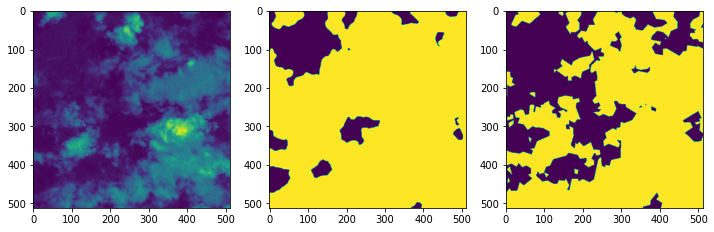

adwz 261947 262144


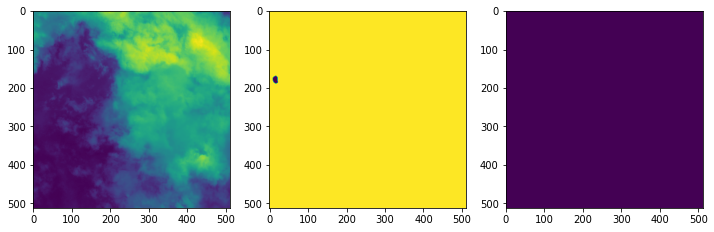

aeig 257143 257138


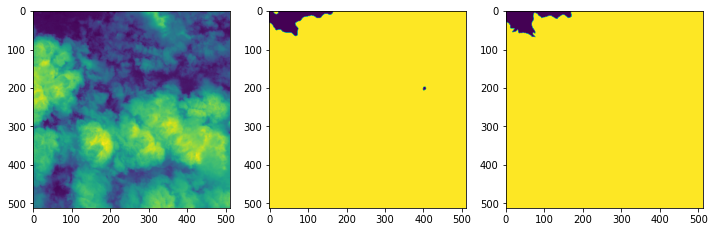

aejo 86236 78946


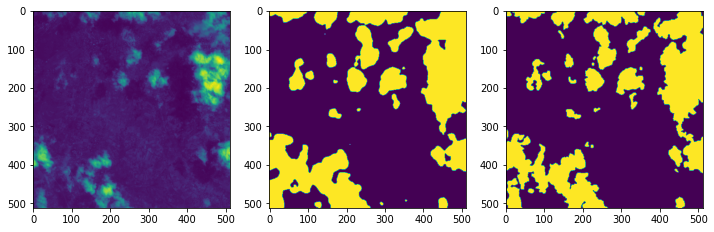

aetz 140587 189253


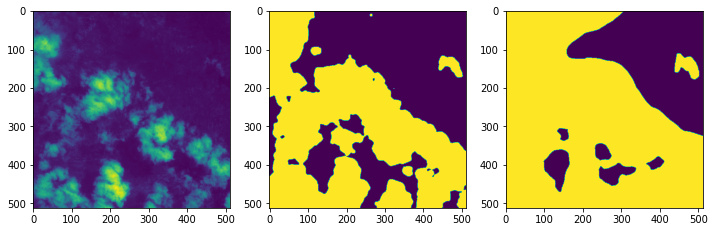

aeue 262144 262144


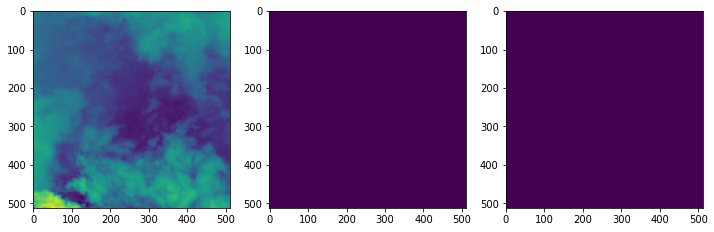

aftk 61420 261947


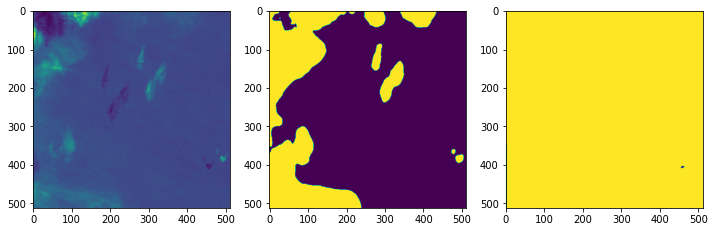

agrp 117656 234451


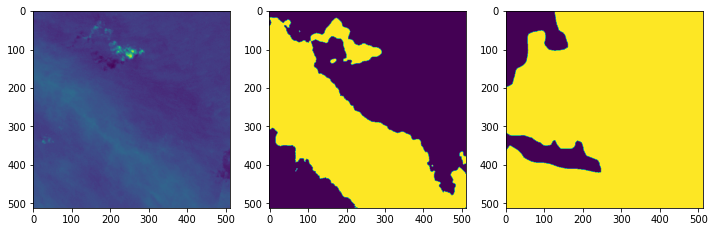

aivi 23043 262131


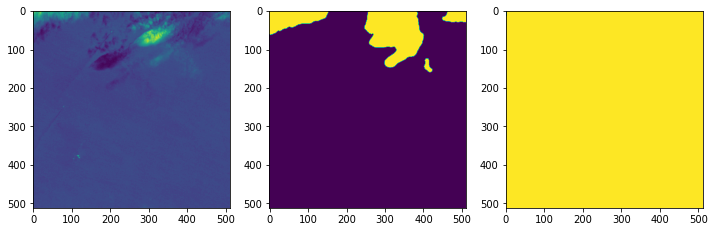

hvif 61122 59970


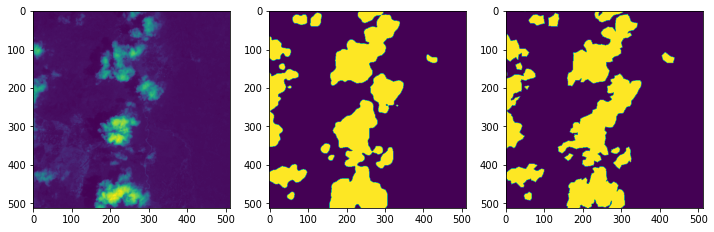

hvik 82245 88674


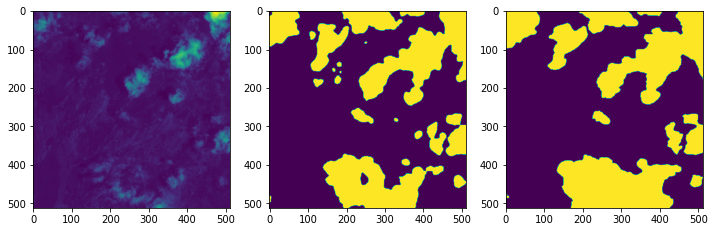

hvjt 8537 7096


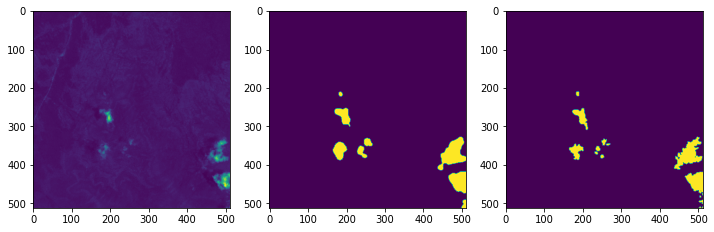

hvla 47114 45855


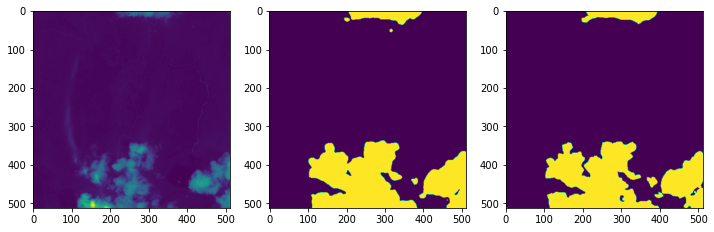

hxdf 91792 1755


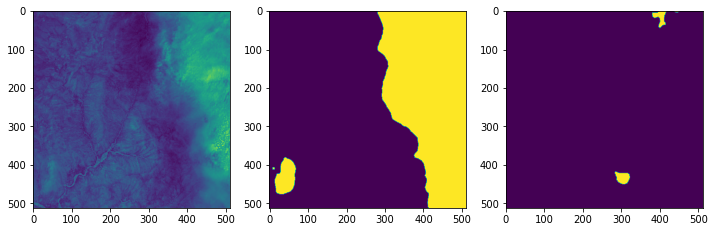

hxec 231063 0


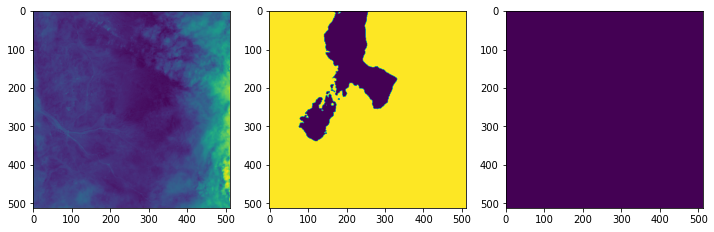

hxfs 262144 16011


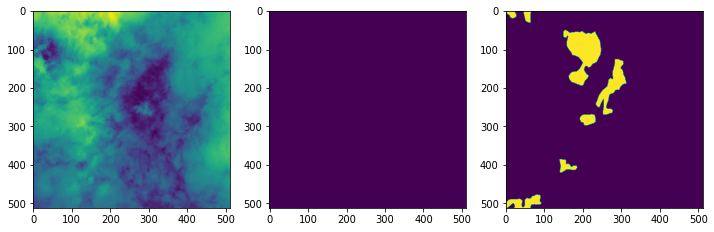

hygu 153643 20947


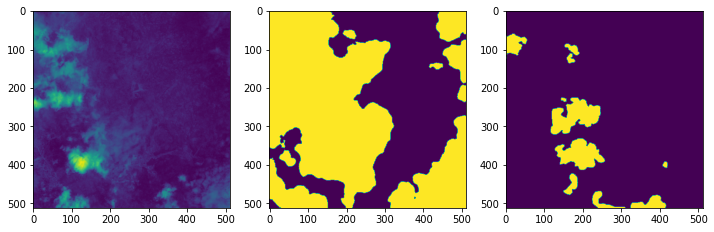

hyms 109912 45450


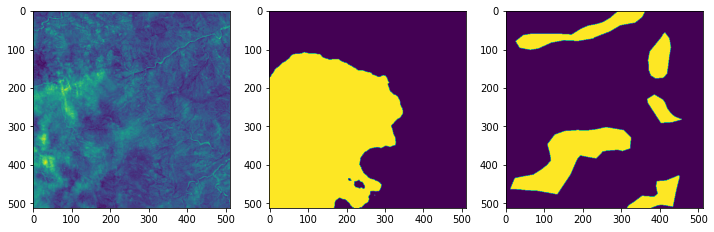

hynv 262144 0


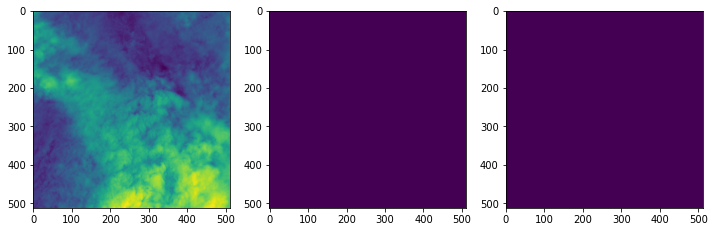

hyoe 262144 694


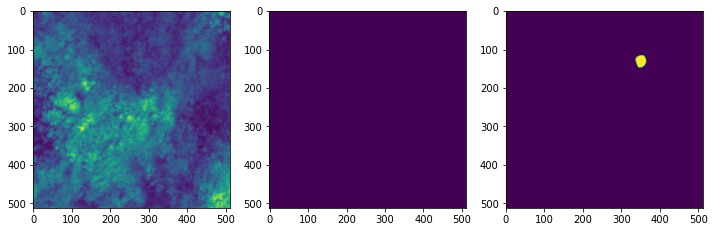

hzdl 202396 2366


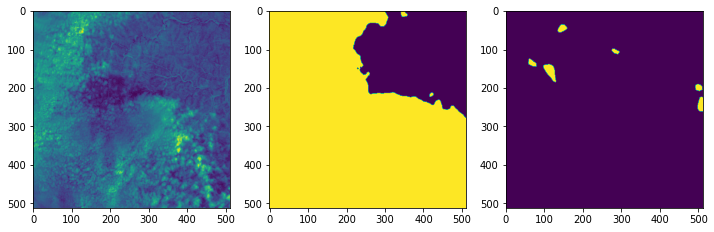

hzgh 3939 6111


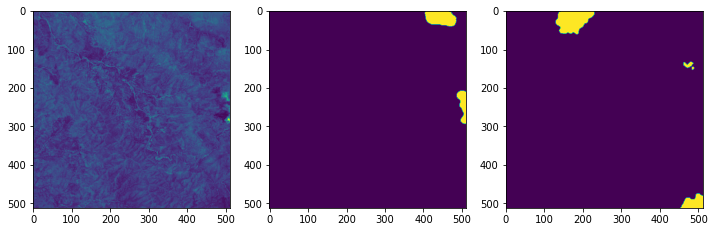

hzhc 54998 6512


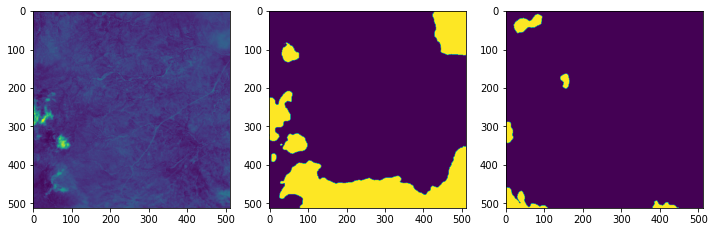

hzju 261656 43


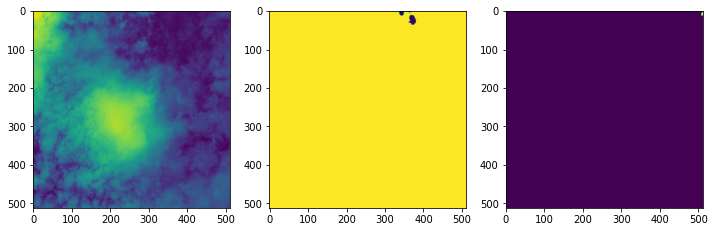

hzwe 251909 0


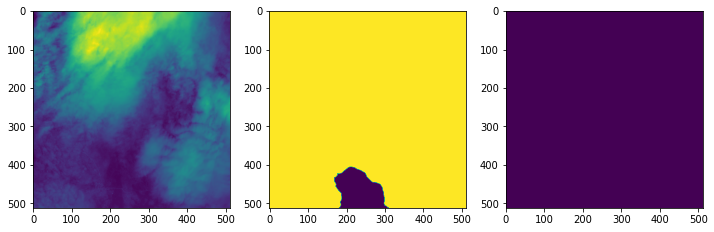

iacl 262144 0


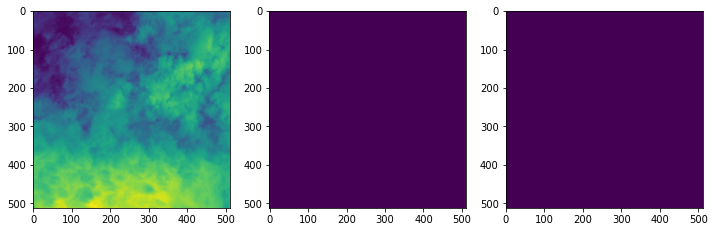

iamf 143557 0


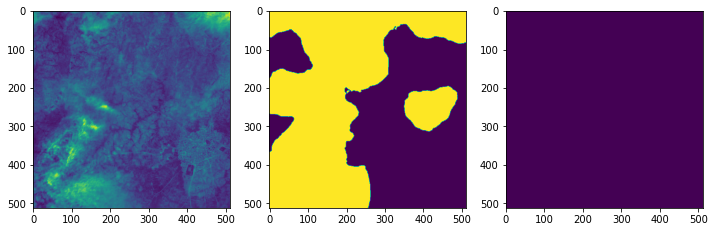

iasx 262141 0


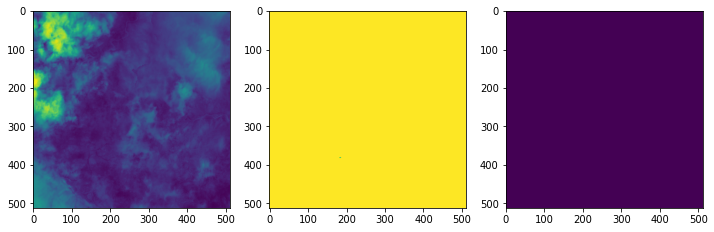

iazd 130947 175428


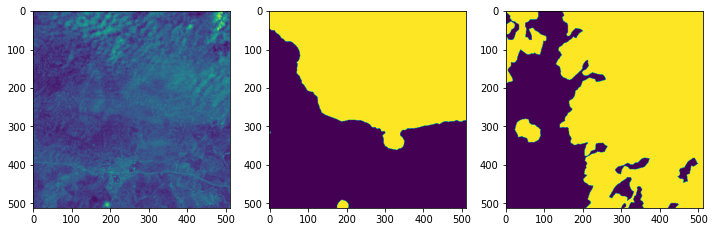

ibcg 9657 181769


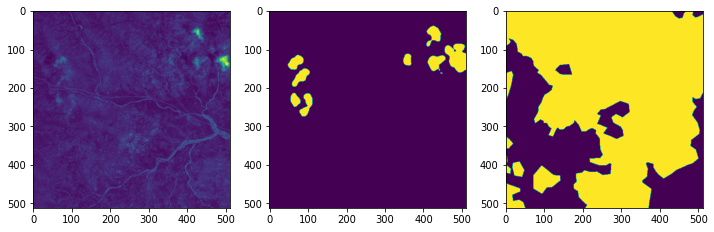

ibdj 262144 259233


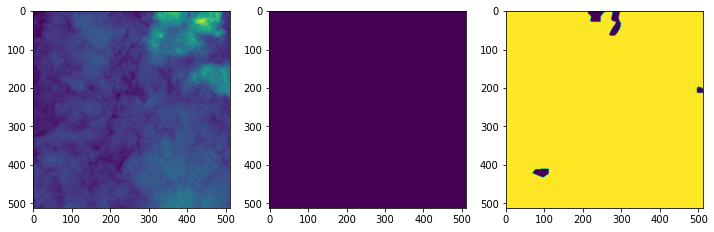

ibep 127558 262144


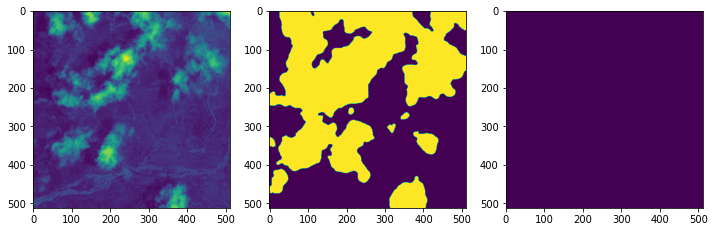

ibjo 123178 194349


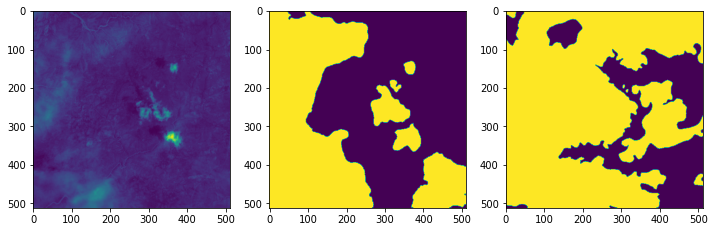

ibld 67092 259344


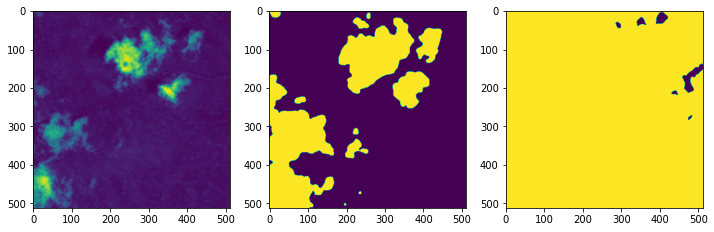

ibot 27789 248392


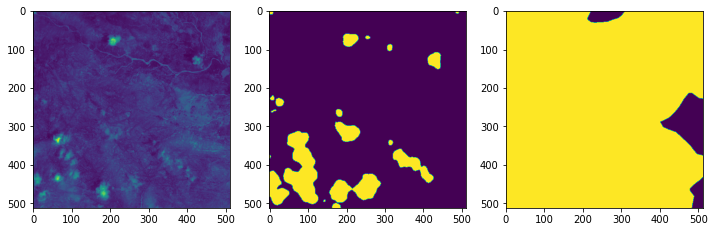

ibpw 84711 107158


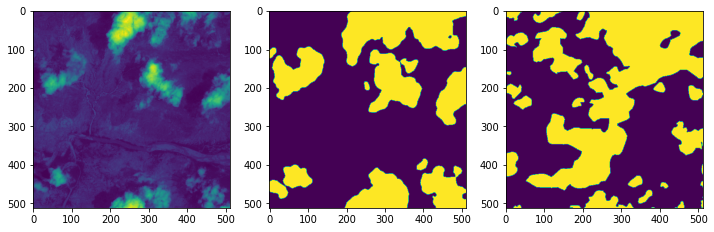

ibpy 262144 0


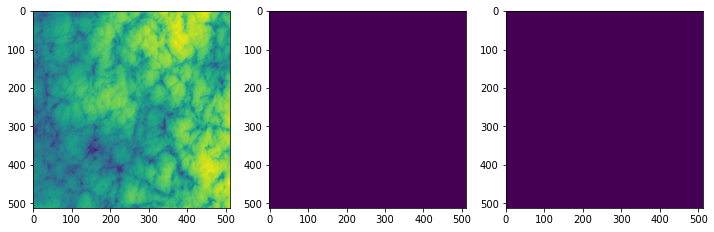

ibqa 72430 261313


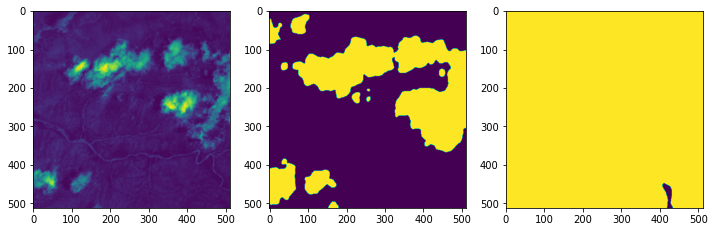

In [12]:
for chip_id in chip_ids:
    with rasterio.open(f'./tmp/{chip_id}') as img_file:
        pimg = img_file.read(1)
    

    with rasterio.open(f'../../data/train_labels/{chip_id}') as img_file:
        lbl = img_file.read(1)
        
    cid =  chip_id.replace('.tif','') 
    with rasterio.open(f'../../data/train_features/{cid}/B02.tif') as img_file:
        img = img_file.read(1)
        
    f, ax = plt.subplots(1,3,figsize=(12,4))
    ax[0].imshow(img)
    ax[1].imshow(pimg)
    ax[2].imshow(lbl)
    
    print(cid,pimg.sum(),lbl.sum())
    
    plt.show()